In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pylab as plt
import geopandas as gpd
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df = pd.read_csv("local84.csv")

In [3]:
del df['Unnamed: 0']

# This transformation is in case your system doesn't recognize the current encoding
cols = df.columns.str.replace('\xc2\xb2', '_2')
df.columns = cols

In [289]:
df.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

In [225]:
df.head(2)

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,...,Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,...,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,...,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN


In [5]:
#5 most recurring property type
df["Primary Property Type - Self Selected"].value_counts().head()

Multifamily Housing           8699
Office                        1233
See Primary BBL                447
Hotel                          236
Non-Refrigerated Warehouse     177
Name: Primary Property Type - Self Selected, dtype: int64

In [6]:
dfh=df[df["Primary Property Type - Self Selected"]=="Multifamily Housing"]

In [7]:
print "For Multi Family Housing there are %i missing values out of %i properties (%.1f percent)" %(dfh['Site EUI (kBtu/ft_2)'].isnull().sum(), 
                                                                        len(dfh), 
                                                                        dfh['Site EUI (kBtu/ft_2)'].isnull().sum()
                                                                          /float(len(df))*100)


For Multi Family Housing there are 45 missing values out of 8699 properties (0.3 percent)


In [8]:
# Drop nans
dfh = dfh.dropna(subset=['Site EUI (kBtu/ft_2)'])
print 'Examples after dropping NaNs:', len(dfh)

Examples after dropping NaNs: 8654


In [9]:
# Drop zero EUI values
dfh = dfh[dfh['Site EUI (kBtu/ft_2)']>0]
print 'Examples after dropping zeros:', len(dfh)

Examples after dropping zeros: 8652


In [10]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    dfh = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return dfh

In [11]:
dfh['eui'] = dfh['Site EUI (kBtu/ft_2)']
dfh['log_eui'] = np.log10(dfh.eui)
dfh = clean(dfh)
print 'Examples after cleaning EUI:', len(dfh)

Examples after cleaning EUI: 8369


In [12]:
dfh.eui.describe()

count    8369.000000
mean       87.188804
std        29.988660
min        21.000000
25%        69.200000
50%        83.400000
75%       101.300000
max       304.800000
Name: eui, dtype: float64

In [13]:
#We load PLUTO by borough
BX = pd.read_csv("BX.csv")
BK = pd.read_csv("BK.csv")
MN = pd.read_csv("MN.csv")
QN = pd.read_csv("QN.csv")
SI = pd.read_csv("SI.csv")

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixe

In [14]:
#we create a full dataset with all 5 boroughs
pluto = pd.concat([BX,BK,MN,QN,SI])

In [15]:
#merging both datasets
ds = pd.merge(pluto, dfh, right_on="NYC Borough, Block and Lot (BBL)", left_on="BBL")

In [16]:
#We check the size of the datasets
print pluto.shape
print dfh.shape
print ds.shape

(858370, 84)
(8369, 59)
(8364, 143)


In [17]:
#We check what data is numeric (float) and can be used without transformation
print pluto.select_dtypes(include=['float64']).shape
print dfh.select_dtypes(include=['float64']).shape
print ds.shape

(858370, 31)
(8369, 28)
(8364, 143)


In [18]:
#We create a new simple location variable with borough asigned to a number
dum_bor={"MN":0.0,"BK":1.0,"BX":2.0,"QN":3.0,"SI":4.0}
ds["Borough"] = ds.Borough_x.map(dum_bor)

In [19]:
#we define a function for removing outliers for an entire dataset
def remove_outliers(ds):
        df_out=ds[(np.abs(stats.zscore(ds)) < 2).all(axis=1)]
        return df_out 

In [20]:
#we define a function to create a new column based on last year built and last alteration
def max_year_buil(ds):
    ds["Last_Age"] = ds[["YearAlter1","YearAlter2","YearBuilt"]].max(axis=1)


In [21]:
max_year_buil(ds)

In [22]:
#The following code gives the correlations for all the numeric variables against EUI
ds.corr()["eui"][ds.corr()["eui"]<0.5]

Block                                                               0.014022
Lot                                                                -0.062655
CD                                                                  0.000208
CT2010                                                              0.023530
CB2010                                                              0.034194
SchoolDist                                                          0.002760
Council                                                            -0.034244
ZipCode                                                            -0.020969
PolicePrct                                                          0.009835
HealthArea                                                         -0.094460
SanitBoro                                                           0.014566
SanitDistrict                                                       0.005612
LandUse                                                             0.015054

From This group of variables, the following were selected to build a model

In [361]:
dsm=ds[[
#Energy
"Total GHG Emissions (Metric Tons CO2e)",
"Natural Gas Use (kBtu)",
"Electricity Use - Grid Purchase (kBtu)",

#NumBldgs
"UnitsTotal",
"Last_Age",


#Dinamic
"Occupancy",


#Location:
"Tract2010",

"LandUse",
    
#Value
"AssessTot",
    
"eui",
"log_eui",
    
"ENERGY STAR Score",

"XCoord",
"YCoord"]]

In [353]:
print "Before removing Nans"
print dsm.shape

Before removing Nans
(8364, 15)


In [362]:
print "After removing Nans"
dsm=dsm.dropna()
print dsm.shape
print
print "After removing outliers"
dsm=remove_outliers(dsm)
print dsm.shape

After removing Nans
(6707, 14)

After removing outliers
(5113, 14)


In [365]:
dsm.describe()

,Total GHG Emissions (Metric Tons CO2e),Natural Gas Use (kBtu),Electricity Use - Grid Purchase (kBtu),UnitsTotal,Last_Age,Occupancy,Tract2010,LandUse,AssessTot,eui,log_eui,ENERGY STAR Score,XCoord,YCoord
count,5113.000000,5.113000e+03,5.113000e+03,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5.113000e+03,5113.000000,5113.000000,5113.000000,5.113000e+03,5113.000000
mean,583.938197,5.009231e+06,1.981803e+06,95.138275,1964.299433,99.915901,4724.210248,3.165265,5.111589e+06,85.949873,1.921041,57.432818,1.002450e+06,216042.040681
std,404.562709,5.046712e+06,1.808284e+06,64.366944,29.303664,0.643044,10885.654212,0.495550,5.814064e+06,21.182258,0.107763,27.438547,1.332361e+04,29964.137902
min,132.400000,0.000000e+00,6.783100e+03,2.000000,1890.000000,95.000000,1.000000,2.000000,6.298800e+04,42.000000,1.623249,1.000000,9.730570e+05,152488.000000
25%,343.300000,1.360373e+06,9.307015e+05,59.000000,1937.000000,100.000000,163.000000,3.000000,1.455300e+06,70.700000,1.849419,36.000000,9.928350e+05,197044.000000
50%,462.500000,4.343390e+06,1.357468e+06,75.000000,1963.000000,100.000000,285.000000,3.000000,2.611842e+06,83.400000,1.921166,61.000000,9.994390e+05,217793.000000
75%,661.800000,6.420600e+06,2.300285e+06,108.000000,1988.000000,100.000000,745.000000,3.000000,6.421500e+06,99.200000,1.996512,81.000000,1.011496e+06,242526.000000
max,3658.600000,4.884000e+07,1.514246e+07,680.000000,2015.000000,100.000000,51602.000000,4.000000,3.137985e+07,147.700000,2.169380,100.000000,1.036880e+06,271831.000000


In [27]:
def makehist(x):
    '''this function creates histograms from a list of column 
    indexes from a pandas dataframe'''
    
    # drop nans
    tmp = dsm[x]
    tmp = tmp.dropna()
        
    # plot2
    plt.hist(tmp.astype(float), bins=200, alpha=0.5)
    plt.title("Histogram - %s" %(x))

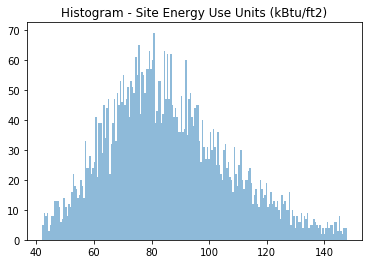

In [366]:
plt.title("Histogram - Site Energy Use Units (kBtu/ft2)")
plt.hist(dsm.eui, bins=200,alpha=0.5);

In [355]:
dsm.eui.describe()

count    5113.000000
mean       85.949873
std        21.182258
min        42.000000
25%        70.700000
50%        83.400000
75%        99.200000
max       147.700000
Name: eui, dtype: float64

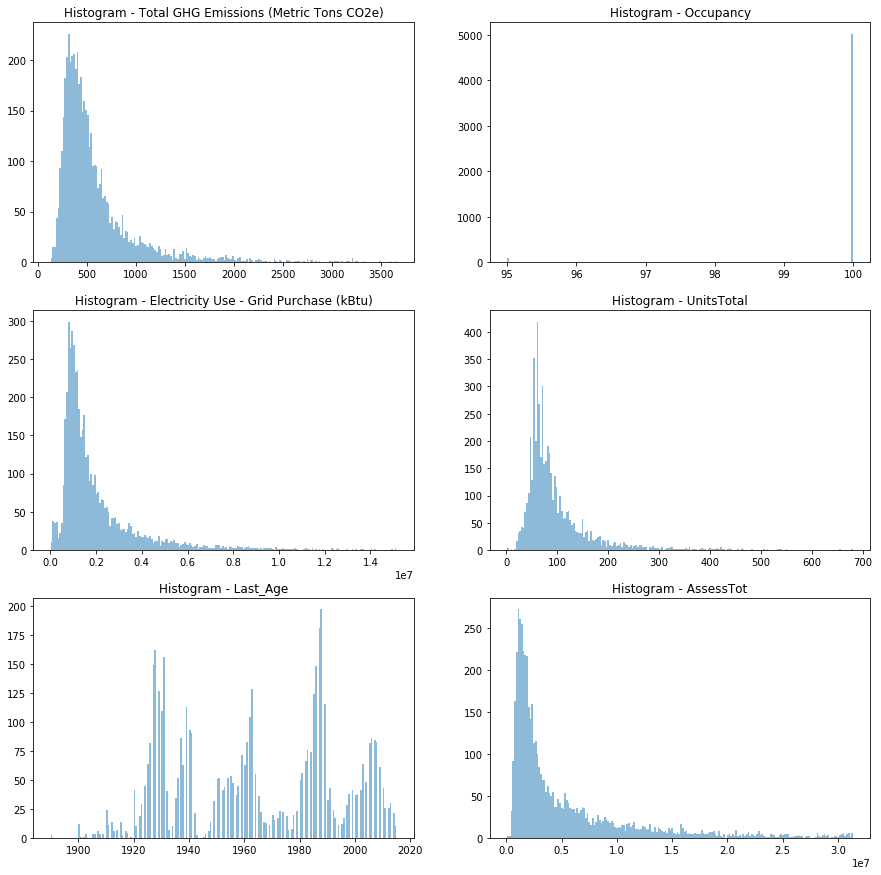

In [368]:
#We will graph some of the relations we found interesting
plt.figure(figsize=(15,15))
for i, var in enumerate(["Total GHG Emissions (Metric Tons CO2e)", "Occupancy", "Electricity Use - Grid Purchase (kBtu)", 'UnitsTotal', 'Last_Age', 'AssessTot'],1):
    plt.subplot(3,2,i)
    makehist(var)

In [31]:
def makeCorrPlots(x, y):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    tmp = dsm[[x,y]]
    tmp = tmp.dropna()
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(tmp[x].astype(float), tmp[y])
    
    # plot2
    plt.scatter(tmp[x].astype(float), tmp[y],  alpha=0.5)
    plt.plot(tmp[x].astype(float),intercept + slope*tmp[x].astype('float'), color='firebrick')
    plt.title('%s v. %s (corr= %.2f)' %(y, x, np.corrcoef(tmp[x].astype('float'), tmp[y])[0][1]))
    
## provided by Sokratis Papadopoulos

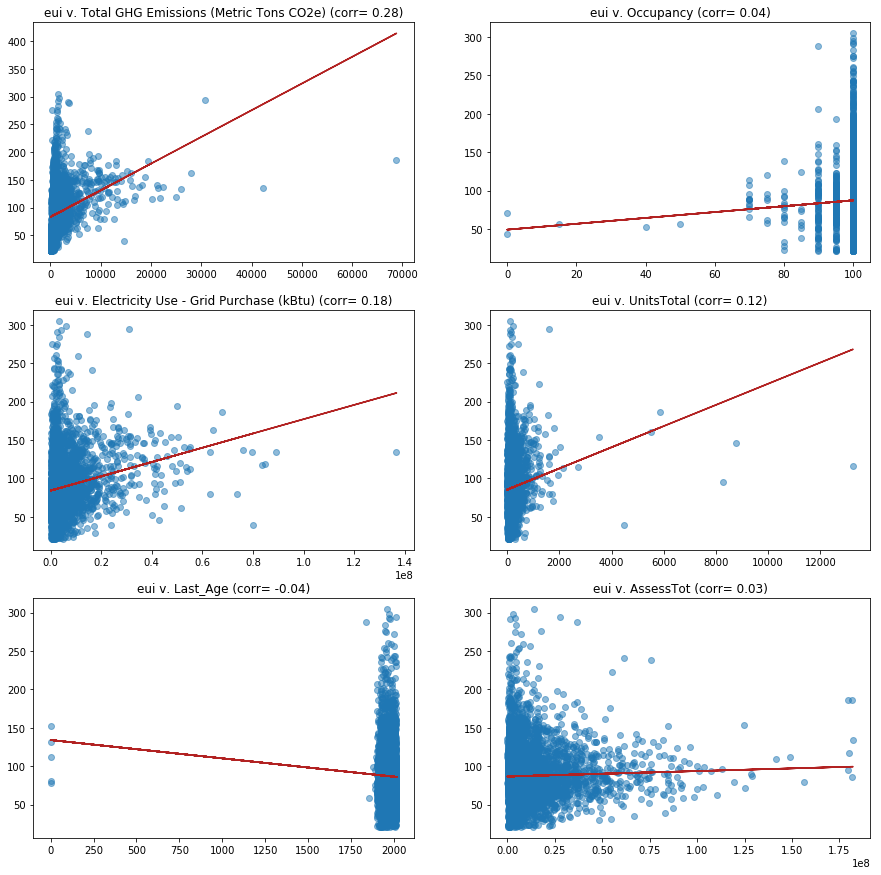

In [348]:
plt.figure(figsize=(15,15))
for i, var in enumerate(["Total GHG Emissions (Metric Tons CO2e)", "Occupancy", "Electricity Use - Grid Purchase (kBtu)", 'UnitsTotal', 'Last_Age', 'AssessTot'],1):
    plt.subplot(3,2,i)
    makeCorrPlots(var, 'eui')

In [370]:
#we change column names for easier use of the linear model function

dsm.columns=[
#Energy
"GHG",
"Gas",
"Electricity",

#NumBldgs
"UnitsTotal",
"Last_Age",

#Dinamic
"Occupancy",

#Location:
"Tract2010",

"LandUse",
    
#Value
"AssessTot",

"eui",
"log_eui",

"Energy_Star",

"XCoord",
"YCoord"]

In [360]:
dsm.describe()

,GHG,Gas,Electricity,UnitsTotal,Last_Age,Occupancy,Tract2010,Borough,LandUse,AssessTot,eui,log_eui,Energy_Star,XCoord,YCoord
count,5113.000000,5.113000e+03,5.113000e+03,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5.113000e+03,5113.000000,5113.000000,5113.000000,5.113000e+03,5113.000000
mean,583.938197,5.009231e+06,1.981803e+06,95.138275,1964.299433,99.915901,4724.210248,1.187757,3.165265,5.111589e+06,85.949873,1.921041,57.432818,1.002450e+06,216042.040681
std,404.562709,5.046712e+06,1.808284e+06,64.366944,29.303664,0.643044,10885.654212,1.082453,0.495550,5.814064e+06,21.182258,0.107763,27.438547,1.332361e+04,29964.137902
min,132.400000,0.000000e+00,6.783100e+03,2.000000,1890.000000,95.000000,1.000000,0.000000,2.000000,6.298800e+04,42.000000,1.623249,1.000000,9.730570e+05,152488.000000
25%,343.300000,1.360373e+06,9.307015e+05,59.000000,1937.000000,100.000000,163.000000,0.000000,3.000000,1.455300e+06,70.700000,1.849419,36.000000,9.928350e+05,197044.000000
50%,462.500000,4.343390e+06,1.357468e+06,75.000000,1963.000000,100.000000,285.000000,1.000000,3.000000,2.611842e+06,83.400000,1.921166,61.000000,9.994390e+05,217793.000000
75%,661.800000,6.420600e+06,2.300285e+06,108.000000,1988.000000,100.000000,745.000000,2.000000,3.000000,6.421500e+06,99.200000,1.996512,81.000000,1.011496e+06,242526.000000
max,3658.600000,4.884000e+07,1.514246e+07,680.000000,2015.000000,100.000000,51602.000000,3.000000,4.000000,3.137985e+07,147.700000,2.169380,100.000000,1.036880e+06,271831.000000


In [359]:
#dsm_nan=dsm.dropna()
ml=smf.ols("eui~GHG+Gas+Electricity+UnitsTotal+Last_Age+Occupancy+Tract2010+LandUse+AssessTot",data=dsm).fit()
ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     188.0
Date:                Mon, 13 Nov 2017   Prob (F-statistic):          2.40e-309
Time:                        23:15:32   Log-Likelihood:                -22133.
No. Observations:                5113   AIC:                         4.429e+04
Df Residuals:                    5103   BIC:                         4.435e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      96.3364     44.381      2.171      0.030       9.332     183.341
GHG             0.0450      0.001     33.991      0.000       0.042       0.048
Gas          2.569e-07   6.97e-08      3.688      0.000     1.2e-07    3.94e-07
Electricity -2.603e-06   2.98e-07     -8.741      0.000   -3.19e-06   -2.02e-06
UnitsTotal     -0.1239      0.007    -18.494      0.000      -0.137      -0.111
Last_Age       -0.0093      0.009     -0.998      0.318      -0.028       0.009
Occupancy      -0.0691      0.401     -0.172      0.863      -0.855       0.717
Tract2010     5.52e-05   2.39e-05      2.306      0.021    8.26e-06       0.000
LandUse         2.6493      0.555      4.769      0.000       1.560       3.738
AssessTot   -8.749e-07   6.55e-08    -13.348      0.000      -1e-06   -7.46e-07
==============================================================================
Omnibus:                      204.912   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              310.199
Skew:                           0.373   Prob(JB):                     4.38e-68
Kurtosis:                       3.948   Cond. No.                     1.66e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
do=df[df["Primary Property Type - Self Selected"]=="Office"]

In [36]:
print "For Office there are %i missing values out of %i properties (%.1f percent)" %(do['Site EUI (kBtu/ft_2)'].isnull().sum(), 
                                                                        len(do), 
                                                                        do['Site EUI (kBtu/ft_2)'].isnull().sum()
                                                                          /float(len(df))*100)


# Drop nans
do = do.dropna(subset=['Site EUI (kBtu/ft_2)'])
print 'Examples after dropping NaNs:', len(do)

# Drop zero EUI values
do = do[do['Site EUI (kBtu/ft_2)']>0]
print 'Examples after dropping zeros:', len(do)

def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

do['eui'] = do['Site EUI (kBtu/ft_2)']
do['log_eui'] = np.log10(do.eui)
do = clean(do)
print 'Examples after cleaning EUI:', len(do)

For Office there are 8 missing values out of 1233 properties (0.1 percent)
Examples after dropping NaNs: 1225
Examples after dropping zeros: 1222
Examples after cleaning EUI: 1190


In [37]:
do = pd.merge(pluto, do, right_on="NYC Borough, Block and Lot (BBL)", left_on="BBL")

In [38]:
#adding last year
max_year_buil(do)

In [40]:
dom=do[[
#Energy
"Total GHG Emissions (Metric Tons CO2e)",
"Electricity Use - Grid Purchase (kBtu)",

#NumBldgs
"UnitsTotal",
"Last_Age",

#Dinamic
"Occupancy",

#Location:
"Tract2010",

"LandUse",
    
#Value
"AssessTot",
    

"eui",
"log_eui"]]

In [41]:
dom.isnull().sum()

Total GHG Emissions (Metric Tons CO2e)    0
Electricity Use - Grid Purchase (kBtu)    1
UnitsTotal                                0
Last_Age                                  0
Occupancy                                 0
Tract2010                                 0
LandUse                                   0
AssessTot                                 0
eui                                       0
log_eui                                   0
dtype: int64

In [42]:
print "Before removing Nans"
print dom.shape
print
print "After removing Nans"
dom=dom.dropna()
print dom.shape
print
print "After removing outliers"
dom=remove_outliers(dom)
print dom.shape

Before removing Nans
(1189, 10)

After removing Nans
(1188, 10)

After removing outliers
(935, 10)


In [43]:
dom.columns=[
#Energy
"GHG",
"Electricity",

#NumBldgs
"UnitsTotal",
"Last_Age",

#Dinamic
"Occupancy",
#"Water",

#Location:
"Tract2010",
"LandUse",
    
#Value
"AssessTot",

"eui",
"log_eui"]

In [44]:
mlo=smf.ols("eui~GHG+Electricity+UnitsTotal+Last_Age+Occupancy+Tract2010+LandUse+AssessTot",data=dom).fit()
mlo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     19.33
Date:                Mon, 13 Nov 2017   Prob (F-statistic):           4.50e-27
Time:                        15:45:02   Log-Likelihood:                -4271.4
No. Observations:                 935   AIC:                             8561.
Df Residuals:                     926   BIC:                             8604.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      84.5736     53.711      1.575      0.116     -20.836     189.983
GHG             0.0151      0.002      9.492      0.000       0.012       0.018
Electricity -8.699e-07   2.19e-07     -3.966      0.000    -1.3e-06   -4.39e-07
UnitsTotal     -0.0338      0.024     -1.404      0.161      -0.081       0.013
Last_Age       -0.0015      0.022     -0.071      0.944      -0.044       0.041
Occupancy       0.3375      0.273      1.238      0.216      -0.197       0.872
Tract2010       0.0010      0.000      3.067      0.002       0.000       0.002
LandUse        -7.5827      2.606     -2.909      0.004     -12.698      -2.468
AssessTot   -2.222e-07   4.87e-08     -4.566      0.000   -3.18e-07   -1.27e-07
==============================================================================
Omnibus:                      100.695   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.365
Skew:                           0.824   Prob(JB):                     1.48e-30
Kurtosis:                       3.899   Cond. No.                     3.48e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we will graph the two models together

In [45]:
del dsm['Gas']
dmodel = pd.concat([dsm,dom])

In [46]:
mmodel=smf.ols("eui~GHG+Electricity+UnitsTotal+Last_Age+Occupancy+Tract2010+LandUse+AssessTot",data=dmodel).fit()
mmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     183.9
Date:                Mon, 13 Nov 2017   Prob (F-statistic):          5.23e-283
Time:                        15:45:02   Log-Likelihood:                -30814.
No. Observations:                6998   AIC:                         6.165e+04
Df Residuals:                    6989   BIC:                         6.171e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      69.0017     25.538      2.702      0.007      18.939     119.064
GHG             0.0312      0.001     33.813      0.000       0.029       0.033
Electricity -2.242e-06   1.39e-07    -16.116      0.000   -2.51e-06   -1.97e-06
UnitsTotal     -0.0641      0.004    -14.511      0.000      -0.073      -0.055
Last_Age       -0.0124      0.008     -1.537      0.124      -0.028       0.003
Occupancy       0.3657      0.198      1.845      0.065      -0.023       0.754
Tract2010      7.1e-05   2.34e-05      3.038      0.002    2.52e-05       0.000
LandUse        -0.4447      0.355     -1.254      0.210      -1.140       0.251
AssessTot    -4.34e-07    3.3e-08    -13.143      0.000   -4.99e-07   -3.69e-07
==============================================================================
Omnibus:                      284.623   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              352.630
Skew:                           0.447   Prob(JB):                     2.67e-77
Kurtosis:                       3.640   Cond. No.                     2.15e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
dsg=ds[[
#Energy
"Total GHG Emissions (Metric Tons CO2e)",
"Natural Gas Use (kBtu)",
"Electricity Use - Grid Purchase (kBtu)",

#NumBldgs
"UnitsTotal",
"Last_Age",


#Dinamic
"Occupancy",


#Location:
"Tract2010",

"LandUse",
    
#Value
"AssessTot",
    
"eui",
"log_eui",

"XCoord",
"YCoord"]]

In [67]:
dsg.isnull().sum()

Total GHG Emissions (Metric Tons CO2e)      2
Natural Gas Use (kBtu)                    676
Electricity Use - Grid Purchase (kBtu)     23
UnitsTotal                                  0
Last_Age                                    0
Occupancy                                   0
Tract2010                                   0
Borough                                     0
LandUse                                     0
AssessTot                                   0
eui                                         0
log_eui                                     0
XCoord                                     13
YCoord                                     13
dtype: int64

In [324]:
.shape

(5113L,)

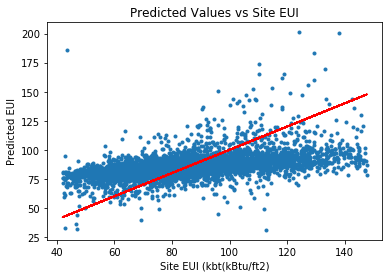

In [335]:
plot(dsm.eui,ml.predict(),".")
plot(dsm.eui,dsm.eui,"-",c="r")
xlabel("Site EUI (kbt(kBtu/ft2)")
ylabel("Predicted EUI")
title("Predicted Values vs Site EUI");

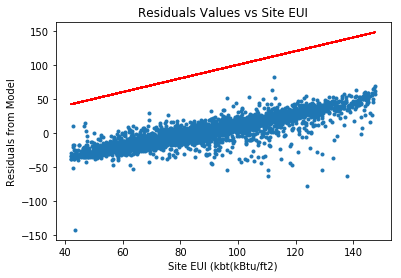

In [334]:
plot(dsm.eui,ml.resid,".")
plot(dsm.eui,dsm.eui,"-",c="r")
xlabel("Site EUI (kbt(kBtu/ft2)")
ylabel("Residuals from Model")
title("Residuals Values vs Site EUI");

In [371]:
dsm["eui"].corr(dsm.Energy_Star)

-0.74406214343586441

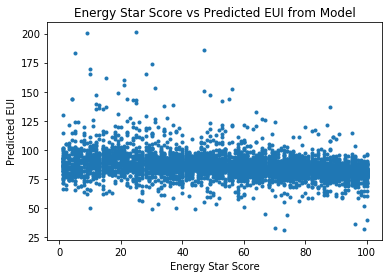

In [343]:
plot(dsm.Energy_Star,ml.predict(),".")
xlabel("Energy Star Score")
ylabel("Predicted EUI")
title("Energy Star Score vs Predicted EUI from Model");

In [372]:
#creating a new column with the predicted values and normalizing them in scale 10
dsm["Bench"]=(ml.predict()/ml.predict().max())*10

In [373]:
#
dsm["Bench"].corr(dsm.Energy_Star)

-0.306407668253249

In [248]:
dsm["Bench"].describe()

count    5787.000000
mean        4.137783
std         0.513618
min         1.515076
25%         3.893616
50%         4.075279
75%         4.312099
max        10.000000
Name: Bench, dtype: float64

In [257]:
dsm["Bench"].round(0).value_counts()

4.0     4666
5.0      717
3.0      269
6.0       82
7.0       28
2.0       16
8.0        5
9.0        3
10.0       1
Name: Bench, dtype: int64

In [284]:
#creating new column to store colors based on model score
bench_color={2.0:"black",3.0:"pink",4.0:"b",5.0:"dark green",6.0:"y",7.0:"orange",8.0:"r",9.0:"r",10.0:"r"}

In [282]:
dsm["Bench_c"]=(dsm["Bench"].round(0)).map(bench_color)

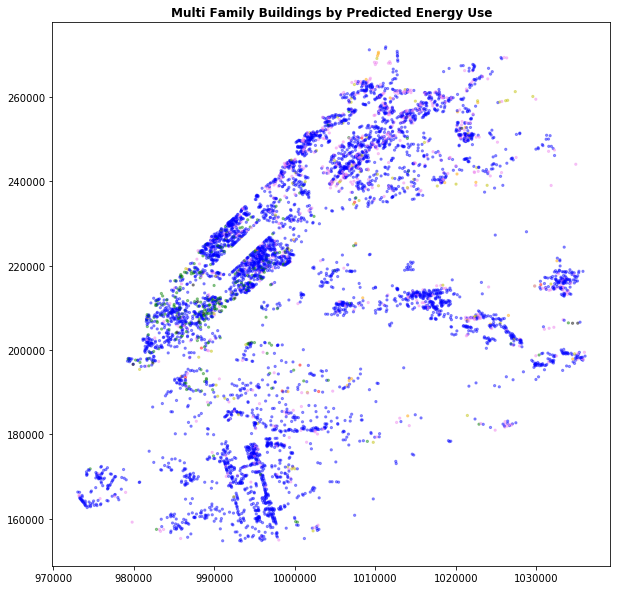

In [295]:
rgbs = [(1-i,i,0) for i in dsm["Bench"]]
cmap = cm.autumn

plt.figure(figsize=(10,10))
plt.scatter((dsm["XCoord"]), (dsm["YCoord"]), c=dsm["Bench_c"], alpha=0.4, s=5);
plt.title("Multi Family Buildings by Predicted Energy Use", weight = "bold")
